In [11]:
import neo4j

host = "bolt://localhost"
username = "neo4j"
password = "1234qwer"

driver = neo4j.GraphDatabase.driver(f'{host}', auth=(username, password))

session = driver.session()

In [6]:
import psycopg2

pg_host = "localhost"
pg_database = "graph"
pg_user = "postgres"
pg_password = "postgres"

# Establish PostgreSQL connection
pg_conn = psycopg2.connect(
    host=pg_host,
    database=pg_database,
    user=pg_user,
    password=pg_password
)
pg_cursor = pg_conn.cursor()

In [16]:
session.run("""
MATCH (p:Requirement)
RETURN gds.graph.project(
  'bertRequirementGraph',
  p,
  null,
  {
    sourceNodeProperties: p { .bert_embedding },
    targetNodeProperties: {}
  }
)
""")

In [18]:
records, summary, key = driver.execute_query("""
CALL gds.knn.stream('bertRequirementGraph', {
    topK: 2,
    nodeProperties: {bert_embedding: 'EUCLIDEAN'},
    randomSeed: 1337,
    concurrency: 1,
    sampleRate: 1.0,
    deltaThreshold: 0.0
})
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).id AS id1, gds.util.asNode(node2).id AS id2, similarity
ORDER BY similarity DESC
""")

for row in records:
    insert_query = """
        INSERT INTO sentence_matching (source_id, target_id, similarity, method, embedding) 
        VALUES (%s, %s, %s, %s, %s)
    """
    pg_cursor.execute(insert_query, (row['id1'], row['id2'], row['similarity'], 'EUCLIDEAN', 'BERT'))
    pg_conn.commit()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [25]:
def plot_score_distribution(scores, title):
    """
    Create a histogram with normal distribution curve for scores
    
    Parameters:
    scores (list): List of numerical scores
    """
    # Convert to numpy array if not already
    scores = np.array(scores)
    
    # Calculate mean and standard deviation
    mean = np.mean(scores)
    std = np.std(scores)
    
    # Create the plot figure and axis
    plt.figure(figsize=(10, 6))
    
    # Create histogram
    counts, bins, _ = plt.hist(scores, bins=20, density=True, alpha=0.7, 
                              color='skyblue', label='Similarity Score Distribution')
    
    # Generate points for the normal distribution curve
    x = np.linspace(min(scores), max(scores), 100)
    pdf = stats.norm.pdf(x, mean, std)
    
    # Plot the normal distribution curve
    #plt.plot(x, pdf, 'r-', lw=2, label='Normal Distribution')
    
    # Add vertical line for mean
    plt.axvline(mean, color='green', linestyle='--', label=f'Mean = {mean:.2f}')
    
    # Customize the plot
    plt.title(title, fontsize=12, pad=15)
    plt.xlabel('Score', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add text box with statistics
    stats_text = f'Mean: {mean:.2f}\nStd Dev: {std:.2f}'
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return plt

In [34]:
# Execute query to select similarities
pg_cursor.execute("""
    SELECT similarity 
    FROM sentence_matching 
    WHERE embedding = 'sBERT' 
    AND method = 'EUCLIDEAN'
""")

# Fetch all results
similarities = pg_cursor.fetchall()

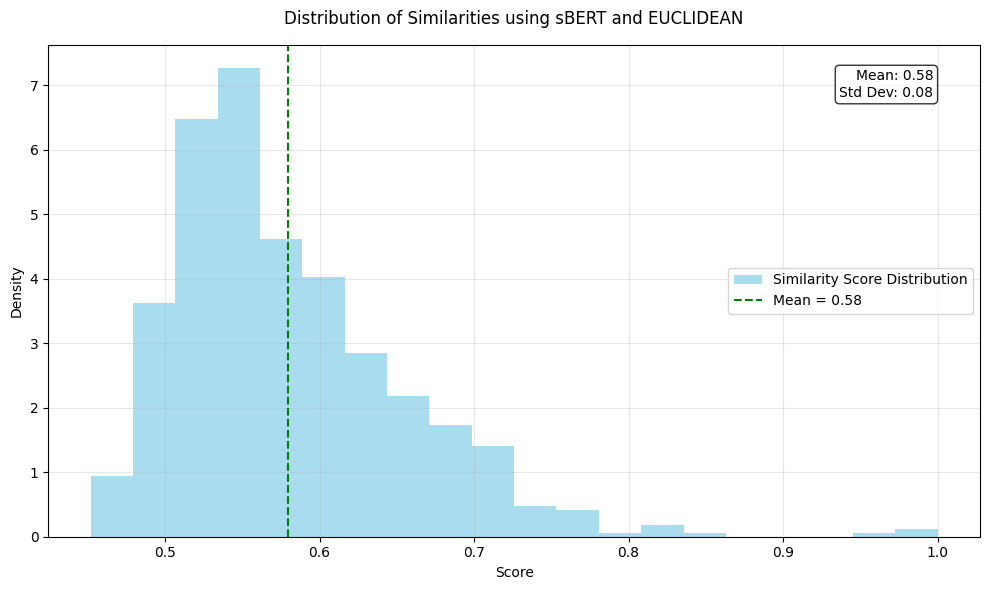

In [35]:
scores = similarities

# Create and display the plot
plot_score_distribution(scores, 'Distribution of Similarities using sBERT and EUCLIDEAN')
plt.show()

In [56]:
from sklearn.metrics import accuracy_score, f1_score

def calculate_f1_score(method, embedding, threshold):
  pg_cursor.execute(f"""
  select 
    prompt_matching.is_match as label, 
    (case when sentence_matching.similarity > {threshold} then true else false end) as predicted
  from 
    (
          select 
            source_id as id1, 
            target_id as id2, 
            is_match 
          from 
            prompt_matching 
          union 
          select 
            target_id as id1, 
            source_id as id2, 
            is_match 
          from 
            prompt_matching
        ) as prompt_matching
    left join (
      select * from sentence_matching 
      where "method" = '{method}' 
      and embedding = '{embedding}'
    ) as sentence_matching on (
      prompt_matching.id1 = sentence_matching.source_id 
      and prompt_matching.id2 = sentence_matching.target_id
    ) 
  """)
  data_predict = pg_cursor.fetchall()
  label = []
  predicted = []
  for data in data_predict:
      label.append(data[0])
      predicted.append(data[1])
  accuracy = accuracy_score(label, predicted)
  f1 = f1_score(label, predicted)

  print(f'Accuracy: {accuracy:.3f}')
  #print(f'F1 Score: {f1:.3f}')

In [58]:
print('COSINE', 'text-embedding-ada-002')
calculate_f1_score('COSINE', 'text-embedding-ada-002', 0.95)
print('EUCLIDEAN', 'text-embedding-ada-002')
calculate_f1_score('EUCLIDEAN', 'text-embedding-ada-002', 0.71)
print('COSINE', 'BERT')
calculate_f1_score('COSINE', 'BERT', 0.99)
print('EUCLIDEAN', 'BERT')
calculate_f1_score('EUCLIDEAN', 'BERT', 0.35)
print('COSINE', 'sBERT')
calculate_f1_score('COSINE', 'sBERT', 0.85)
print('EUCLIDEAN', 'sBERT')
calculate_f1_score('EUCLIDEAN', 'sBERT', 0.58)

COSINE text-embedding-ada-002
Accuracy: 0.725
EUCLIDEAN text-embedding-ada-002
Accuracy: 0.711
COSINE BERT
Accuracy: 0.537
EUCLIDEAN BERT
Accuracy: 0.633
COSINE sBERT
Accuracy: 0.718
EUCLIDEAN sBERT
Accuracy: 0.712
